# Fixed wing drone swarm pursuit

## Imports

In [ ]:
import pygame
from pygame.math import Vector2
from math import *, ceil, sqrt
import numpy as np
import random as rd
from IPython.display import Image
import time
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString

## Constants

### Global constants

In [ ]:
# controler constants
k_position = 1
k_velocity = 1
k_angle_penalty = 1
k_velocity_penalty = 1
k_theta = 1
k_omega = 0.01

# display settings
width = 1280
height = 720

### Swarm constants

In [ ]:
N_drones = 5
launch_position = np.zeros(2)

#collision control constants
ref_angle = 20 #20°
k_front_angle = 100
k_collision_angle = 200
k_angle_velocity = 10000
k_collision_acceleration = 5
k_spacing = 1.3

## Main classes & functions

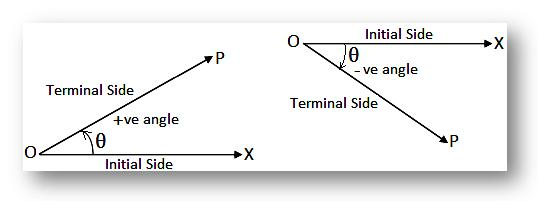

In [ ]:
Image(filename='images/signed_angle.jpg') 

In [ ]:
#returns the signed angle between two vectors u and v
def signed_angle(u, v):
    angle = atan2(v[1], v[0]) - atan2(u[1], u[0])
    angle = degrees(angle)
    if angle > 180:
        angle -= 360
    elif angle < -180:
        angle += 360
    return angle

def add_gaussian_noise(vec, mean=0, std_dev=1, size = 2):
    noise = np.random.normal(mean, std_dev, size)
    return vec + noise

def computeDistance(drone, zone) :
    '''Computes the distance between a drone and a zone

    Args:
          drone (Drone): a drone
          zone (2 dimension float list): list of zone outline coordinates
    
    Returns:
          rect.distance(point) (float): min distance between drone and zone
    '''
    rect = Polygon(zone)
    drone_pos = (drone.position.x, drone.position.y)
    point = Point(drone_pos)
    return rect.distance(point)

def divide_ring_zone(center, inner_radius, outer_radius, nb_zones):
    '''Divides a ring zone into multiple sub zones
    
    Args:
         center (tuple): center of the ring
         inner_radius (float): radius of the inner circle of the ring
         outer_radius (float): radius of the outer cirlce of the ring
         nb_zones (int)
    Returns:
         sub_zones (3 dimension float list): list of sub zones outline coordinates
    '''
    center = Point(center[0], center[1])
    inner_circle = center.buffer(inner_radius)
    outer_circle = center.buffer(outer_radius)

    # Divide inner and outer circle in nb_zones near equal parts
    sub_arrays_inner = np.array_split(inner_circle.exterior.coords, nb_zones)
    sub_arrays_outer = np.array_split(outer_circle.exterior.coords, nb_zones)
    # Add connection points to sub arrays 
    for i in range(nb_zones) :
        sub_arrays_inner[i] = np.concatenate((sub_arrays_inner[i], [sub_arrays_inner[(i+1)%nb_zones][0]]), axis=0)
        sub_arrays_outer[i] = np.concatenate((sub_arrays_outer[i], [sub_arrays_outer[(i+1)%nb_zones][0]]), axis=0)
        
    # Sub zones creation
    sub_zones = []
    for i in range(nb_zones):
        # Concatenate outer circle part with the corresponding inner circle part to create the sub zone
        concat = np.concatenate((np.flip(sub_arrays_inner[i], axis=0), sub_arrays_outer[i]))
        sub_zone = Polygon(concat)
        # Coords of sub zone
        zone_coords = []
        for coord in sub_zone.exterior.coords:
            zone_coords.append([coord[0], coord[1]])
        sub_zones.append(zone_coords)
    return sub_zones


def compute_mesh(assignment_list) :
    '''Computes a list of mesh over a list of zones

    Args:
          assignment_list (tuple (Drone, 2 dimension float list)): list of couples (drone, zone assigned)
    Returns :
          zones_mesh (2 dimension list of float) : a list of lists of mesh points coordinates for each each zone
    '''
    
    zones_list = [sub_list[1] for sub_list in assignment_list]
    mesh_size = 0.3
    
    # Coordinates to Polygon objects
    zones_mesh = []
    for zone in zones_list :
        poly = Polygon(zone)
        # Limits of polygon
        min_x, min_y, max_x, max_y = poly.bounds
        
        # Construct square mesh 
        x_coords = np.arange(min_x, max_x + mesh_size, mesh_size)
        y_coords = np.arange(min_y, max_y + mesh_size, mesh_size)
        mesh_x, mesh_y = np.meshgrid(x_coords, y_coords)
        mesh_points = np.column_stack((mesh_x.ravel(), mesh_y.ravel()))

        # Extract points belonging to the polygon
        mask = [poly.contains(Point(p[0], p[1])) for p in mesh_points]
        mesh_points = mesh_points[mask]
        indices = []
        for i in range(len(mesh_points)-1) :
            print("coucou")
            if (math.dist(mesh_points[i], mesh_points[i+1]) > mesh_size*4) :
                indices.append(i+1)
                print("Indice : ", i+1)

        for i in range(len(indices)-1) :
            if (i%2 == 0) :
                mesh_points[indices[i]:indices[i+1]] = mesh_points[indices[i]:indices[i+1]][::-1]
        zones_mesh.append(mesh_points)
    
    return zones_mesh


def print_assignment(assignment_list, left_drones_list, left_zones_list, zones_mesh) :
    '''Prints the result of the assignement

    Args:
         assignment_list (tuple (Drone, 2 dimension list)): list of couples (drone, zone assigned)
         left_drones_list (2 dimension float list): list of unassigned drones (if number of drones > number of zones)
         left_zones_list (3 dimension float list): list of unassigned zones outline coordinates (if number of zones > number of drones)
         zones_mesh (list of tuples) : list of points coordinates of the mesh
    Returns:
    '''
    no_of_colors = len(assignment_list)
    color = ["#"+''.join([random.choice('123456789ABCDEF') for i in range(6)]) for j in range(no_of_colors)]
    for i, (drone, zone) in enumerate(assignment_list) :
        print(i)
        plt.plot(drone.position.x, drone.position.y, marker='1', c=color[i])
        x_coords = []
        y_coords = []
        for (x, y) in zone :
            x_coords.append(x)
            y_coords.append(y)
        plt.plot(x_coords, y_coords, c=color[i])
        x_coords = []
        y_coords = []
        graph, = plt.plot([], [], 'o')
        for (x, y) in zones_mesh[i] :
             plt.plot(x, y, marker='+', c=color[i])
             #plt.pause(0.1)
    for drone in left_drones_list :
        plt.scatter(drone.position.x, drone.position.y, marker='1', c='black')
    for zone in left_zones_list :
        x_coords = []
        y_coords = []
        for (x, y) in zone :
            x_coords.append(x)
            y_coords.append(y)
        plt.plot(x_coords, y_coords, c='black')
    #plt.show(block=True)
    plt.show()


### Vehicle class

To control the vehicle, uncomment this cell and comment the next Vehicle class cell.

You may use the arrow keys of your keyboard to control the vehicle.

In [ ]:
class Vehicle:
    def __init__(self, x, y, scaling=1, angle_0=0.0, length_0=4, max_steering_0=30, max_acceleration_0=5.0, k_steering_0=30, brake_deceleration_0=10, free_deceleration_0=2, max_velocity_0=30):
        self.position = Vector2(x, y)
        self.velocity = Vector2(0.0, 0.0)
        self.angle = angle_0
        self.length = length_0
        self.max_acceleration = max_acceleration_0
        self.max_steering = max_steering_0
        self.max_velocity = max_velocity_0/scaling
        self.brake_deceleration = brake_deceleration_0
        self.free_deceleration = free_deceleration_0
        self.k_steering = k_steering_0
        self.scaling = scaling

        self.acceleration = 0.0
        self.steering = 0.0

    def update(self, dt):
        # User input
        pressed = pygame.key.get_pressed()

        if pressed[pygame.K_UP]:
            if self.velocity.x < 0:
                self.acceleration = self.brake_deceleration
            else:
                self.acceleration += (1/self.scaling) * dt
        elif pressed[pygame.K_DOWN]:
            if self.velocity.x > 0:
                self.acceleration = -self.brake_deceleration
            else:
                self.acceleration -= (1/self.scaling) * dt
        elif pressed[pygame.K_SPACE]:
            if abs(self.velocity.x) > dt * self.brake_deceleration:
                self.acceleration = -copysign(self.brake_deceleration, self.velocity.x)
            else:
                self.acceleration = -self.velocity.x / dt
        else:
            if abs(self.velocity.x) > dt * self.free_deceleration:
                self.acceleration = -copysign(self.free_deceleration, self.velocity.x)
            else:
                if dt != 0:
                    self.acceleration = -self.velocity.x / dt
        self.acceleration = max(-self.max_acceleration, min(self.acceleration, self.max_acceleration))

        #steering
        if pressed[pygame.K_RIGHT]:
            self.steering -= self.k_steering*dt
        elif pressed[pygame.K_LEFT]:
            self.steering += self.k_steering*dt
        else:
            self.steering = 0
        self.steering = max(-self.max_steering, min(self.steering, self.max_steering))

        #velocity update
        self.velocity += (self.acceleration * dt, 0)
        self.velocity.x = max(-self.max_velocity, min(self.velocity.x, self.max_velocity))

        if self.steering:
            turning_radius = self.length / sin(radians(self.steering))
            angular_velocity = self.velocity.x / turning_radius
        else:
            angular_velocity = 0

        self.position += self.velocity.rotate(-self.angle) * dt
        self.angle += degrees(angular_velocity) * dt

In [ ]:
'''
class Vehicle:
    def __init__(self, x=10, y=10, angle=0.0, length=4, max_steering=40, max_acceleration=2, min_acceleration=-2, scaling=1,
                 max_velocity_0=10, min_velocity_0=-10):
        self.position = Vector2(x, y)
        self.velocity = Vector2(0.0, 0.0)
        self.angle = angle
        self.length = length
        self.max_acceleration = max_acceleration
        self.min_acceleration = min_acceleration
        self.max_steering = max_steering
        self.max_velocity = max_velocity_0
        self.min_velocity = min_velocity_0
        self.brake_deceleration = 1
        self.free_deceleration = 0.2

        self.max_velocity = max_velocity_0/scaling
        self.min_velocity = min_velocity_0/scaling

        self.steering_acc = 0.0
        self.acceleration = 0.0
        self.steering = 0.0

    def update(self, dt):
        self.acceleration = rd.gauss(1,2)
        self.acceleration = max(self.min_acceleration, min(self.acceleration, self.max_acceleration))

        self.steering_acc = rd.gauss(0,70)
        self.velocity += (self.acceleration * dt, 0)
        self.velocity.x = max(self.min_velocity, min(self.velocity.x, self.max_velocity))
        self.steering += self.steering_acc*dt
        self.steering = max(-self.max_steering, min(self.steering, self.max_steering))
        if abs(self.steering) == self.max_steering:
            self.steering = 0
        if self.steering:
            turning_radius = self.length / sin(radians(self.steering))
            angular_velocity = self.velocity.x / turning_radius
        else:
            angular_velocity = 0

        self.position += self.velocity.rotate(-self.angle) * dt
        self.angle += degrees(angular_velocity) * dt
'''

'\nclass Vehicle:\n    def __init__(self, x=10, y=10, angle=0.0, length=4, max_steering=40, max_acceleration=2, min_acceleration=-2, scaling=1,\n                 max_velocity_0=10, min_velocity_0=-10):\n        self.position = Vector2(x, y)\n        self.velocity = Vector2(0.0, 0.0)\n        self.angle = angle\n        self.length = length\n        self.max_acceleration = max_acceleration\n        self.min_acceleration = min_acceleration\n        self.max_steering = max_steering\n        self.max_velocity = max_velocity_0\n        self.min_velocity = min_velocity_0\n        self.brake_deceleration = 1\n        self.free_deceleration = 0.2\n\n        self.max_velocity = max_velocity_0/scaling\n        self.min_velocity = min_velocity_0/scaling\n\n        self.steering_acc = 0.0\n        self.acceleration = 0.0\n        self.steering = 0.0\n\n    def update(self, dt):\n        self.acceleration = rd.gauss(1,2)\n        self.acceleration = max(self.min_acceleration, min(self.acceleration,

### Drone class

In [ ]:
class Drone:
    def __init__(self, x, y, scaling=1, angle_0=0, length_0=1, max_steering_0=30, max_acceleration_0=5.0, k_steering_0=30,
                 brake_deceleration_0=10, free_deceleration_0=2, max_velocity_0=30, min_velocity_0=10,
                 target_position_0=Vector2(0,0), swarm_index_0=0, vision_radius_0=100):
        self.position = Vector2(x, y)
        self.velocity = Vector2(0.0, 0.0)
        self.angle = angle_0
        self.length = length_0
        self.max_acceleration = max_acceleration_0
        self.max_steering = max_steering_0
        self.max_velocity = max_velocity_0/scaling
        self.min_velocity = min_velocity_0/scaling
        self.brake_deceleration = brake_deceleration_0
        self.free_deceleration = free_deceleration_0
        self.k_steering = k_steering_0
        self.swarm_index = swarm_index_0
        self.vision_radius = vision_radius_0

        try:
            self.previous_theta = acos(Vector2.dot(target_position_0, Vector2(1.0, 0.0))/Vector2.magnitude(target_position_0)) - self.angle
        except:
            self.previous_theta = 0
        self.acceleration = 0.0
        self.steering = 0.0

    def angle_calculation(self, target_position):
        v = Vector2.normalize(target_position - self.position) # à bruiter parce qu'on connait pas la position exacte
        #v = add_gaussian_noise(v,mean=0,std_dev=0.5)
        v[1] = -v[1] # attention ca donne l'angle dans la base "écran" sinon
        u = Vector2(1.0, 0.0).rotate(self.angle) #obtenable avec un gyroscope
        
        theta = signed_angle(u, v)
        return theta

    def chase(self, dt, last_target_position, last_target_velocity, drone_positions, drone_velocities):
        # Deltas
        del_position = Vector2.magnitude(last_target_position - self.position)
        del_velocity = Vector2.magnitude(last_target_velocity - self.velocity)

        theta = self.angle_calculation(last_target_position)

        #print(target_position.y, target_position.x)
        del_theta = (theta - self.previous_theta)

        self.previous_theta = theta

        collision_angle = 0
        collision_acceleration = 0

        # Avoiding collisions
        if (len(drone_positions) > 1):
            for i in range(len(drone_positions)):
                if (i != self.swarm_index):
                    # Angle
                    del_position = Vector2.magnitude(drone_positions[i] - self.position)
                    del_velocity = np.sign(Vector2.dot(self.velocity, drone_velocities[i]))*Vector2.magnitude(drone_velocities[i] - self.velocity)
                    angle = self.angle_calculation(drone_positions[i])
                    #print(f"drone:{self.swarm_index},       angle:{round(angle, 2)},      del_pos:{round(del_position, 2)}")
                    
                    if (self.position != drone_positions[i]):
                        angle = self.angle_calculation(drone_positions[i])
                        if ((angle >= -ref_angle) & (angle <= ref_angle)):
                            collision_angle += -np.sign(angle)*k_front_angle*(1 + (1.0/del_position**2) + k_angle_velocity*(1.0/del_velocity**2))
                        else:
                            #if a drone is on the right, turn left and vice versa
                            #collision_angle += (1.0/del_position**2)*abs(sin(angle*pi/180.0))
                            collision_angle += -np.sign(angle)*(1.0/del_position**2)

                    # Acceleration
                    if ((angle >= -90) & (angle <= 90)):
                        #if a drone is in front, decelerate
                        collision_acceleration -= (1.0/del_position**2)*abs(cos(angle*pi/180.0))
                        #collision_acceleration -= (1.0/del_position**2)
                    else:
                        #if a drone is behind, accelerate
                        collision_acceleration += (1.0/del_position**2)*abs(cos(angle*pi/180.0))
                        #collision_acceleration += (1.0/del_position**2)

        #Gaz pedal controller
        self.acceleration = k_position*del_position + k_velocity*del_velocity + k_collision_acceleration*collision_acceleration
        self.acceleration = max(-self.max_acceleration, min(self.acceleration, self.max_acceleration))
        #self.acceleration = 0

        #steering controller
        #self.steering = k_theta*theta + k_omega*del_theta + k_collision_angle*collision_angle - k_velocity_penalty*Vector2.magnitude(self.velocity)/self.max_velocity
        self.steering = k_theta*theta + k_omega*del_theta + k_collision_angle*collision_angle
        self.steering = k_theta*theta
        self.steering = max(-self.max_steering, min(self.steering, self.max_steering))

        #velocity update
        self.velocity += Vector2(self.acceleration*dt, 0.0) 
        self.velocity.x = max(self.min_velocity, min(self.velocity.x, self.max_velocity))
        #self.velocity.y = max(self.min_velocity, min(self.velocity.y, self.max_velocity))

        if self.steering:
            turning_radius = self.length/sin(radians(self.steering))
            angular_velocity = self.velocity.x/turning_radius
        else:
            angular_velocity = 0

        self.position += self.velocity.rotate(-self.angle) * dt
        self.angle += degrees(angular_velocity) * dt
    
    def update(self, dt, target_position, target_velocity, ppu, last_target_position=Vector2(0,0), last_target_velocity=Vector2(0,0), drone_positions=[], drone_velocities=[], state=0):
        if (state==0):
            # car in vision
            self.chase(dt, target_position, target_velocity, drone_positions, drone_velocities)
        
        elif (state==1):
            # searching car
            try:
                normal_vector = Vector2.rotate(Vector2.normalize(last_target_velocity), 90)
                virtual_target_position = last_target_position + k_spacing*(pow(-1, self.swarm_index)*floor((self.swarm_index+1)/2)*(1/ppu)*self.vision_radius)*normal_vector
            except:
                virtual_target_position = last_target_position.copy()
            if (self.swarm_index==0):
                virtual_target_position = last_target_position
            self.chase(dt, virtual_target_position, last_target_velocity, drone_positions, drone_velocities)

### Draw function

Used to display either the image of the drone or the car on the screen, accordingly to the object's current attributes

In [ ]:
def draw(drone, car, car_image, drone_image, ppu, game, car_drawn=0):
    if (car_drawn==1):
        rotated_car = pygame.transform.rotate(car_image, car.angle)
        rect = rotated_car.get_rect()
        car_position = car.position * ppu
        car_position = [car_position[0]%width, car_position[1]%height]
        car_new_position =  [car_position[0] - rect.width/2, car_position[1] - rect.height/2]
        game.screen.blit(rotated_car, car_new_position)

    else:
        rotated_drone = pygame.transform.rotate(drone_image, drone.angle)
        rect = rotated_drone.get_rect()
        drone_position = drone.position * ppu
        drone_position = [drone_position[0]%width, drone_position[1]%height]
        drone_new_position =  [drone_position[0] - rect.width/2, drone_position[1] - rect.height/2]
        game.screen.blit(rotated_drone, drone_new_position)

        if (Vector2.magnitude(drone.position - car.position)*ppu > drone.vision_radius):
            color_0 = (255,0,0)
        else:
            color_0 = (0,255,0)
        pygame.draw.circle(center = drone_position, radius=drone.vision_radius, surface=game.screen, color=color_0, width=1)
    return

## Swarm related classes

### Swarm class

In [ ]:
class Swarm():
    def __init__(self, N_drones_0, launch_position_0, scaling_drone=1, state_0, target_position_0=Vector2(0,0), zones_list):
        self.swarm_list = []
        self.drone_positions = []
        self.drone_velocities = []
        self.N_drones = N_drones_0
        self.state = state_0
        self.last_target_position = target_position_0
        self.last_target_velocity = Vector2(0,0)
        self.zones_list = zones_list

        for i in range(self.N_drones):
            position = launch_position_0 + np.random.normal(loc=0, scale=10, size=2)
            x = position[0]
            y = position[1]
            self.swarm_list.append(Drone(x=x, y=y, scaling=scaling_drone, swarm_index_0=i))
            self.drone_positions.append(self.swarm_list[i].position)
            self.drone_velocities.append(self.swarm_list[i].velocity)

    def assignment(self) :
        '''Assigns each drone to a zone

        Returns:
              assignment_list (tuple (Drone, 2 dimension float list)): list of couples (drone, zone assigned)
              list(set(drones_list) - set(assigned_drones)) (2 dimension Drone list): list of unassigned drones (if number of drones > number of zones)
              zones_list (3 dimension float list): list of unassigned zones outline coordinates (if number of zones > number of drones)
        '''
        drones_list = self.swarm_list
        zones_list = self.zones_list
        if not drones_list or not zones_list :
            print("No drone or no zone for assignment")
        assignment_list = []
        assigned_drones = []
        for drone in drones_list :
            if zones_list : 
                d_min = computeDistance(drone, zones_list[0])
                zone_min = zones_list[0]
                for zone in zones_list :
                    d = computeDistance(drone, zone)
                    if d < d_min :
                        d_min = d
                        zone_min = zone
                zones_list.remove(zone_min)
                assigned_drones.append(drone)
                assignment_list.append((drone, zone_min))
        return assignment_list, list(set(drones_list) - set(assigned_drones)), zones_list

   
    def update(self, dt, target_position, target_velocity, ppu) :
        # Pursuit swarm
        if (self.state == 0) :
            for i in range(self.N_drones) :
                if (Vector2.magnitude(self.swarm_list[i].position - target_position)*ppu < self.swarm_list[i].vision_radius) :
                    self.last_target_position = target_position.copy()
                    self.last_target_velocity = target_velocity.copy()
                    self.state = 0

            # ordering the drones so they are sorted along each associated virtual car
            '''
            affectation_dict = {}
            if (self.state==0):
                try:
                    normal_vector = Vector2.rotate(Vector2.normalize(target_velocity), 90)
                    for i in range(self.N_drones):
                        affectation_dict[i] = Vector2.dot(self.swarm_list[i].position - target_position, normal_vector)
                        sorted_dict = sorted(affectation_dict, key=lambda x:-x[1])

                        tmp = []
                        for i in range(self.N_drones):
                            tmp.append(self.swarm_list[sorted_dict[i, 0]])
                        self.swarm_list = tmp
                except:
                    pass
            '''

            '''
            affectation_dict = {}
            if (self.state==0):
                try:
                    colinear_vector = Vector2.normalize(target_velocity)
                    normal_vector = Vector2.rotate(Vector2.normalize(target_velocity), 90)
                
                    #Calculate the first virtual car position
                    try:
                        if ((N_drones % 2)==1):
                            first_virtual_position = target_position + k_spacing*(pow(-1, N_drones)*floor((N_drones+1)/2)*(1/ppu)*self.vision_radius)*normal_vector
                        else:
                            first_virtual_position = target_position + k_spacing*(pow(-1, N_drones - 1)*floor(N_drones/2)*(1/ppu)*self.vision_radius)*normal_vector
                    except:
                        first_virtual_position = target_position
                    #first_virtual_position = target_position
                    #Calculate the signed distance between the first virtual car position and the i_th drone projection 
                    for i in range(self.N_drones):
                        if (normal_vector[0]!=0):
                            a = colinear_vector[1]/colinear_vector[0]
                            b = target_position[1] - target_position[0]*a
                            alpha = atan2(normal_vector[1], normal_vector[0])
                            p = abs(self.swarm_list[i].position[0] - (self.swarm_list[1] - b)/a)*sin(alpha)
                            tmp_position = self.swarm_list[i].position + p*colinear_vector
                            affectation_dict[i] = Vector2.dot(tmp_position - first_virtual_position, colinear_vector)
                        else:
                            affectation_dict[i] = first_virtual_position[1] - self.swarm_list[i].position[1]

                        #sorting the dictionary along the calculated distances
                        sorted_dict = sorted(affectation_dict, key=lambda x:x[1])

                        #reindexing the drone swarm list following the newly calculated indexation
                        tmp_list = []
                        for i in range(self.N_drones):
                            tmp_list.append(self.swarm_list[sorted_dict[i, 0]])
                        self.swarm_list = tmp_list
                except:
                    pass
            '''
        

            for i in range(self.N_drones):
                self.swarm_list[i].update(dt, target_position, target_velocity,
                                        ppu=ppu,
                                        last_target_position=self.last_target_position,
                                        last_target_velocity=self.last_target_velocity,
                                        drone_positions=self.drone_positions,
                                        drone_velocities=self.drone_velocities,
                                        state=self.state,)
                self.drone_positions[i] = self.swarm_list[i].position
                self.drone_velocities[i] = self.swarm_list[i].velocity
                
        if (self.state == 1):
                self.last_target_position += self.last_target_velocity*dt

        # Cartography swarm
        elif(self.state == 2) :
            assignment_list, self.swarm_list, self.zones_list = self.assignment()
            self.state = 0
        

    def draw(self, car, car_image, drone_image, ppu, game):
        for i in range(self.N_drones):
            draw(drone=self.swarm_list[i], car=car, car_image=car_image, drone_image=drone_image, ppu=ppu, game=game, car_drawn=0)

### Swarm game

In [ ]:
class Swarm_game:
    def __init__(self):
        pygame.init()
        pygame.display.set_caption("Drone pursuit")
        self.screen = pygame.display.set_mode((width, height))
        self.clock = pygame.time.Clock()
        self.ticks = 60
        self.exit = False

    def run(self):
        car_image_path = "car.png"
        drone_image_path = "drone.png"
        car_image = pygame.image.load(car_image_path)
        drone_image = pygame.image.load(drone_image_path)
        taille_car = car_image.get_size()
        scaling_car = 10
        taille_car = [taille_car[0]/scaling_car, taille_car[1]/scaling_car]
        car_image = pygame.transform.scale(car_image, taille_car)

        taille_drone = drone_image.get_size()
        scaling_drone = 10
        taille_drone = [taille_drone[0]/scaling_drone, taille_drone[1]/scaling_drone]

        car_image = pygame.transform.scale(car_image, taille_car)
        drone_image = pygame.transform.scale(drone_image, taille_drone)

        car = Vehicle(x=10, y=10, scaling=scaling_car)
        swarm = Swarm(N_drones_0=N_drones, scaling_drone=scaling_drone, launch_position_0=launch_position, target_position_0=car.position)
        ppu = 32

        while not self.exit:
            dt = self.clock.get_time() / 1000

            # Event queue
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.exit = True

            # Logic
            car.update(dt)

            swarm.update(dt, target_position=car.position, target_velocity=car.velocity, ppu=ppu)
            
            # Drawing
            self.screen.fill((0, 0, 0))
            draw(drone=0, car=car, car_image=car_image, drone_image=drone_image, ppu=ppu, game=self, car_drawn=1)
            swarm.draw(car=car, car_image=car_image, drone_image=drone_image, ppu=ppu, game=self)
            
            pygame.display.flip()

            self.clock.tick(self.ticks)
        pygame.quit()

## Run swarm simulation

In [ ]:
game = Swarm_game()
game.run()

C:\Users\antho\AppData\Local\Temp\ipykernel_14376\2101808511.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  collision_angle += -np.sign(angle)*k_front_angle*(1 + (1.0/del_position**2) + k_angle_velocity*(1.0/del_velocity**2))
C:\Users\antho\AppData\Local\Temp\ipykernel_14376\2101808511.py:63: RuntimeWarning: invalid value encountered in double_scalars
  collision_angle += -np.sign(angle)*k_front_angle*(1 + (1.0/del_position**2) + k_angle_velocity*(1.0/del_velocity**2))


KeyboardInterrupt: 